In [1]:
import enchant
import numpy as np
import pandas as pd

from wordcloud import WordCloud
from matplotlib import pyplot as plt

from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# What are we loading into memory and working with?

We are working with a dataset that is analyzing whether a given SMS text message is spam, denoted 'spam', or not, denoted 'ham'. The text, and the classification, are the only two file attributes.

Lets load the dataset into memory, and take a look at it.

In [2]:
#Reading in 'Spam SMS' dataset into memory
spamPath = '/home/samsuri/DataSets/SmsSpam/spam.csv'
#Latin encoding must be used, invalid encoding for utf-8
df = pd.read_csv(spamPath, encoding="latin", usecols=[0,1], names=['classification', 'text'], skiprows=1)
#Lowercasing all text in 'text' column
df['text'] = df['text'].str.lower()

In [3]:
#Looking at our data
df.head(10)

,classification,text
0,ham,"go until jurong point, crazy.. available only ..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor... u c already then say...
4,ham,"nah i don't think he goes to usf, he lives aro..."
5,spam,freemsg hey there darling it's been 3 week's n...
6,ham,even my brother is not like to speak with me. ...
7,ham,as per your request 'melle melle (oru minnamin...
8,spam,winner!! as a valued network customer you have...
9,spam,had your mobile 11 months or more? u r entitle...


# What are the most common words?
## Lets create a word cloud  graphic and see
Using a word cloud graphic, we can take a look at the most common words, which will appear larger in the word cloud, as upposed to less common words, which will appear smaller

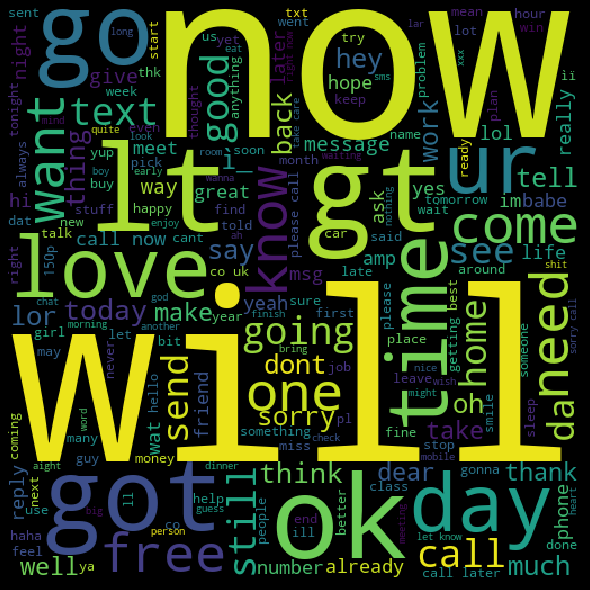

In [4]:
#Getting list of all SMS texts
smsTexts = []
for index,row in df.iterrows():
    smsTexts.append(row['text'])

#Joining SMS texts into a single string
allTextsString = (' ').join(smsTexts)

#Creating word cloud graphic and displaying
wc = WordCloud(width=512, height=512).generate(allTextsString)
plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## We can now see some common words
So as we can see, the words: 'now', 'will', 'got', 'it', love', 'ur', 'ok' are all very frequent, but does any one of these frequent words explain for a large amount of variability in end spam classification?

# Do the most common words account for a lot of variability?
## Lets do a Principal Component Analysis to find out

In [5]:
#List of all SMS texts
documentList = df['text']
vect = CountVectorizer()
#Frequency count matrix of all words in SMS texts
countMatrix = vect.fit_transform(documentList)
tokenizedDf = pd.DataFrame(countMatrix.toarray(), columns=vect.get_feature_names())

#Encoding SMS texts for ML algorithms
resultEncodingDict = {'ham': 1, 'spam': 0}
resultList = df['classification']
resultList.replace(resultEncodingDict, inplace=True)
xTrain, xTest, yTrain, yTest = train_test_split(tokenizedDf, resultList, test_size=.3, random_state=123)

In [6]:
#Numpy array of frequency counts on tokenized SMS texts
frequencyCounts = tokenizedDf.values
#Encoded 'spam'/'ham' Series
encodedClassication = resultList.values

In [7]:
#Standardizing frequency count matrix
standardizedFreqCounts = StandardScaler().fit_transform(frequencyCounts)

In [8]:
#Only looking at PC1 and PC2
pca = PCA(n_components=2)
princComp = pca.fit_transform(standardizedFreqCounts)

In [9]:
#Concatinating pc1, pc2, and encoded classification array
princDf = pd.DataFrame(princComp, columns=['pc1', 'pc2'])
mergedPrincDf = pd.concat([princDf, pd.Series(encodedClassication, name='classification')], axis=1)
mergedPrincDf.head()

,pc1,pc2,classification
0,-0.129148,-0.313474,1
1,-0.092974,-0.330700,1
2,-0.100751,-0.498851,0
3,-0.096245,-0.194324,1
4,-0.032621,0.036053,1


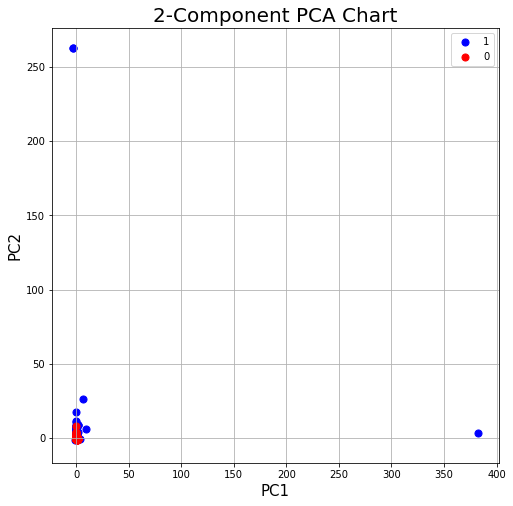

In [10]:
#Plotting data, to get a visual representation
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
#Adding x and y labels
ax.set_xlabel('PC1', fontsize=15)
ax.set_ylabel('PC2', fontsize=15)
#Adding title
ax.set_title('2-Component PCA Chart', fontsize=20)

classifications = [1, 0]
colors = ['b', 'r']
#Plotting scatter graph
for classification, color in zip(classifications, colors):
    indicesToKeep = mergedPrincDf['classification'] == classification
    ax.scatter(mergedPrincDf.loc[indicesToKeep, 'pc1'], 
               mergedPrincDf.loc[indicesToKeep, 'pc2'], 
               c=color, s=50)
    
ax.legend(classifications)
ax.grid()

In [11]:
#Looking at varience each explained by PC1 and PC2
pc1Var, pc2Var = pca.explained_variance_ratio_
print(f'Varience explained by pc1 is: {pc1Var*100:.3f}%')
print(f'Varience explained by pc2 is: {pc2Var*100:.3f}%')

Varience explained by pc1 is: 0.304%
Varience explained by pc2 is: 0.293%


## PCA does not yield many answers

As we can see, performing a Principal Component Analysis is not effective at all on finding a particular dimension that carries more weight than any other, this makes sense given that each SMS text has so many words in them.

# Lets investigate some keywords that may be of interest

By looking at specific words, such as 'free' and 'winning', we might be able to increase the chance that PCA will find a dimension that demonstrates high variability. Lets investigate...

In [12]:
freeBool = []
winBool = []
interestedBool = []
buyBool = []
dollarSignBool = []
offerBool = []
exclaimBool = []
questionBool = []

#Dictionary of lists that represent important features
keyWordDict = {'free': freeBool, 'win': winBool, 'interested': interestedBool, 'buy': buyBool, 
               '$': dollarSignBool, 'offer': offerBool, '!': exclaimBool, '?': questionBool}

#Seeing if each important feature is in each SMS text
#Appending boolean result
for index, row in df.iterrows():
    for keyWord, keyList in keyWordDict.items():
        if keyWord in row.text:
            keyList.append(1)
        else:
            keyList.append(0)

In [13]:
#Creating dataframe from import features lists
keyWordDf = pd.DataFrame(list(zip(freeBool, winBool, interestedBool, buyBool, 
                          dollarSignBool, offerBool, exclaimBool, questionBool)),
                          columns=['Free', 'Win', 'Interested', 'Buy', 'DollarSign',
                                  'Offer', 'Exclamation', 'Question'])

keyWordDf.head()

,Free,Win,Interested,Buy,DollarSign,Offer,Exclamation,Question
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0


In [14]:
#Standardizing frequency count matrix
standardizedFreqCounts = StandardScaler().fit_transform(keyWordDf)

In [15]:
#Only looking at PC1 and PC2
pca = PCA(n_components=2)
princComp = pca.fit_transform(standardizedFreqCounts)

In [16]:
#Concatinating pc1, pc2, and encoded classification array
princDf = pd.DataFrame(princComp, columns=['pc1', 'pc2'])
mergedPrincDf = pd.concat([princDf, pd.Series(encodedClassication, name='classification')], axis=1)
mergedPrincDf.head()

,pc1,pc2,classification
0,-0.474373,-0.162376,1
1,-0.474373,-0.162376,1
2,4.619581,1.386276,0
3,-0.474373,-0.162376,1
4,-0.474373,-0.162376,1


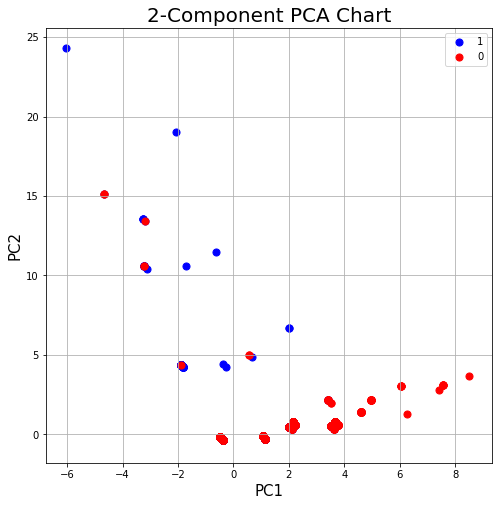

In [17]:
#Plotting data, to get a visual representation
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
#Adding x and y labels
ax.set_xlabel('PC1', fontsize=15)
ax.set_ylabel('PC2', fontsize=15)
#Adding title
ax.set_title('2-Component PCA Chart', fontsize=20)

classifications = [1, 0]
colors = ['b', 'r']
#Plotting scatter graph
for classification, color in zip(classifications, colors):
    indicesToKeep = mergedPrincDf['classification'] == classification
    ax.scatter(mergedPrincDf.loc[indicesToKeep, 'pc1'], 
               mergedPrincDf.loc[indicesToKeep, 'pc2'], 
               c=color, s=50)
    
ax.legend(classifications)
ax.grid()

In [18]:
#Looking at varience each explained by PC1 and PC2
pc1Var, pc2Var = pca.explained_variance_ratio_
print(f'Varience explained by pc1 is: {pc1Var*100:.3f}%')
print(f'Varience explained by pc2 is: {pc2Var*100:.3f}%')

Varience explained by pc1 is: 15.412%
Varience explained by pc2 is: 14.176%


## 2-Dimensions do account for more variability
So when we restrict the number of dimensions to certain key traits, the top traits do account for more variability when stripped of many of the words that are not key traits

# Given our first PCA analysis, let's see how some common algorithms perform on the original data set?

Lets first investigate the performance of some common algorithms:
- MultinomialNB
- Logistic Regression
- Support Vector Machine

Given that we are doing binary classification, logistic regression, should be included. For all algorithms, the text will tokenized into words, using a bag-of-words approach.

### MultinomialNB

In [19]:
mnb = MultinomialNB()
mnb.fit(xTrain, yTrain)
accuracy_score(yTest, mnb.predict(xTest))*100

98.14593301435407

### Logistic Regression

In [20]:
lr = LogisticRegression()
lr.fit(xTrain, yTrain)
accuracy_score(yTest, lr.predict(xTest))*100

/home/samsuri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


98.26555023923444

### Support Vector Machine

In [21]:
svc = SVC(gamma='auto')
svc.fit(xTrain, yTrain)
accuracy_score(yTest, svc.predict(xTest))*100

87.14114832535886

## Preliminary Results

Clearly, MultinomialNB and Logistic Regression did the best, whereas SVC did the worst. This is most likely because though the data is in a very high dimension, given that the number of columns is established over the entire vocabulary of the 'text' column, it not not easily seperatable, regardless of the kernal used.

Also, because an optimum soft margin had to be found, SVC was the slowest of the methods.

MultinomialNB did very well considering its speed and simplicity. It was particularly well suited for the bag-of-words technique on the text data.

# Can we do better?
## Lets Strip out words that are not valid English
Our best result was 98.27% accuracy by using logistic regression. Can we do better? By striping out words that are not valid English, such as numbers, slang, and giberish, we can isolate words that ideally we derive more meaning from.

For example, the word 'free' might be significant, though its weight is diluted when there are many other words. Lets see the effect of only including valid English words...

In [22]:
#Establishing a set of all valid words in the English dictionary
dictionary = enchant.Dict('en_US')

#New dataframe will have only valid English words
#along with bools to represent '!' and '?' being present or not 
exclaimMark = []
questionMark = []
cleanedText = []
for index, row in df.iterrows():
    tempList = []
    #Tokenizing text in each row of dataframe
    tokenList = word_tokenize(row['text'])
    
    exclaimBool = 0
    questionBool = 0
    for possibleWord in tokenList:
        #Seeing if '!' is present
        if possibleWord == '!':
            exclaimBool = 1
        #Seeing if '?' is present
        elif possibleWord == '?':
            questionBool = 1
        #Seeing if each words in SMS text is in NTLK dictionary
        elif dictionary.check(possibleWord) == True:
            if (len(possibleWord) == 1) and (possibleWord not in ['a', 'A', 'i', 'I']):
                continue
            else:
                tempList.append(possibleWord)
    
    exclaimMark.append(exclaimBool)
    questionMark.append(questionBool)
    cleanedText.append(' '.join(tempList))

In [23]:
#Rebuilding frequency count matrix for SMS text
dictVect = CountVectorizer()
dictCountMatrix = dictVect.fit_transform(cleanedText)

#Converting frequency count matrix to numpy array
#Converting lists to numpy array
dictCountMatrix = dictCountMatrix.toarray()
exclaimMarkArr = np.array([exclaimMark])
questionMarkArr = np.array([questionMark])

#Concatinating numpy arrays along vertical axis
dictMatrix = np.concatenate([dictCountMatrix, exclaimMarkArr.T, questionMarkArr.T], axis=1)

#Adding new columns in order columns were concatinated
dictColumns = dictVect.get_feature_names() + ['Exclamation'] + ['Question']
dictionaryDf = pd.DataFrame(dictMatrix, columns=dictColumns)

In [24]:
#Looking at our data, where the text is only valid English
data = [(cleanedText[i], exclaimMark[i], questionMark[i]) for i in range(len(cleanedText))]
unsplitDf = pd.DataFrame(data, columns = ['Text', 'ExclamationMark', 'QuestionMark'])
unsplitDf.head(20)

,Text,ExclamationMark,QuestionMark
0,go until point crazy.. available only in great...,0,0
1,... joking ...,0,0
2,free entry in a wkly comp to win fa cup final ...,0,0
3,dun say so early ... already then say ...,0,0
4,nah i do think he goes to he lives around here...,0,0
5,hey there darling it been week now and no word...,1,1
6,even my brother is not like to speak with me t...,0,0
7,as per your request has been set as your for a...,0,0
8,winner as a valued network customer you have b...,1,0
9,had your mobile 11 months or more entitled to ...,1,1


In [25]:
#Looking at our data, when the text is tokenized with frequency counts
dictionaryDf.head(10)

,00,000,008704050406,0089,0121,01223585236,01223585334,0125698789,02,0207,...,yr,yrs,yummy,yup,zebra,zed,zeros,zoom,Exclamation,Question
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


## Now, lets re-run our tests

In [26]:
xTrain, xTest, yTrain, yTest = train_test_split(dictMatrix, resultList, test_size=.3, random_state=123)

## MultinomialNB

In [27]:
mnb = MultinomialNB()
mnb.fit(xTrain, yTrain)
accuracy_score(yTest, mnb.predict(xTest))*100

97.66746411483254

## Logistic Regression

In [28]:
lr = LogisticRegression()
lr.fit(xTrain, yTrain)
accuracy_score(yTest, lr.predict(xTest))*100

/home/samsuri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


98.02631578947368

## Non-English words are important
Our accuracy actually went down, for MultinomialNB, by .478%, and for Logistic Regression, by .24%. That means we eliminated some key columns when filtering out non-valid English words. 

# Going back to the second PCA analysis, what if we only include keywords that are of interest?
Lets see the accuracy of our Machine Learning algorithms if we only include boolean results on whether the words and punctiation, 'Free', 'Win', 'Interested', 'Buy', '$', 'Offer', '!', '?', are present or not. Instead of using Multinomial Naive Bayes, we will be using Bernoulli Naive Bayes, as that is better suited for binary features

In [29]:
resultList = df['classification']
xTrain, xTest, yTrain, yTest = train_test_split(keyWordDf, resultList, test_size=.3, random_state=123)

In [30]:
bnb = BernoulliNB()
bnb.fit(xTrain, yTrain)
accuracy_score(yTest, bnb.predict(xTest))*100

90.13157894736842

In [31]:
lr = LogisticRegression()
lr.fit(xTrain, yTrain)
accuracy_score(yTest, lr.predict(xTest))*100

/home/samsuri/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


89.71291866028707

It seems that though the key words and punctuation we included do account for more variability than many other words, they still do not account for enough to make provide higher accuracy then when training on the full data set